# Predicción del riesgo de enfermedad cardíaca: Tarea de regresión logística

## Contexto introductorio
Las enfermedades cardíacas son la principal causa de muerte en el mundo, cobrándose aproximadamente 18 millones de vidas al año, según la Organización Mundial de la Salud. Modelos predictivos como la regresión logística permiten la identificación temprana de pacientes en riesgo mediante el análisis de características clínicas como la edad, el colesterol y la presión arterial. Esto no solo mejora los resultados del tratamiento, sino que también optimiza la asignación de recursos en los entornos sanitarios. En esta tarea, implementarás la regresión logística en el conjunto de datos de enfermedades cardíacas: una colección de repositorios UCI del mundo real con 303 registros de pacientes, 14 características y un objetivo binario (1 para presencia de enfermedad, 0 para ausencia). Entrenarás modelos, visualizarás límites, aplicarás regularización y explorarás la implementación mediante Amazon SageMaker para simular un pipeline de producción.

Importar librerias

In [28]:
%pip install numpy matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Cargar y preparar el conjunto de datos

In [30]:

# Cargar el archivo CSV
df = pd.read_csv("Heart_Disease_Prediction.csv")

# Ver las primeras filas del dataset
print("Primeras 5 filas del dataset:")
print(df.head())
print("\n" + "="*80 + "\n")

# Información sobre el dataset
print("Información del dataset:")
print(df.info())
print("\n" + "="*80 + "\n")

# Estadísticas descriptivas
print("Estadísticas descriptivas:")
print(df.describe())
print("\n" + "="*80 + "\n")

# Ver la columna de destino
print("Valores únicos en 'Heart Disease':")
print(df['Heart Disease'].value_counts())
print("\n" + "="*80 + "\n")

# Binarizar la columna de destino: 1 = Presence (enfermedad), 0 = Absence (sin enfermedad)
df['Heart Disease'] = (df['Heart Disease'] == 'Presence').astype(int)

print("Después de binarizar:")
print(df['Heart Disease'].value_counts())
print("\nPrimeras filas después de binarizar:")
print(df.head())

Primeras 5 filas del dataset:
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium Heart Disease  
0                        3         3      Presence  
1                        0         7       Absence  


6. ANÁLISIS DE CORRELACIONES

Correlación de características con 'Heart Disease':
Heart Disease              1.000000
Thallium                   0.525020
Number of vessels fluro    0.455336
Exercise angina            0.419303
ST depression              0.417967
Chest pain type            0.417436
Slope of ST                0.337616
Sex                        0.297721
Age                        0.212322
EKG results                0.182091
BP                         0.155383
Cholesterol                0.118021
FBS over 120              -0.016319
Max HR                    -0.418514
Name: Heart Disease, dtype: float64


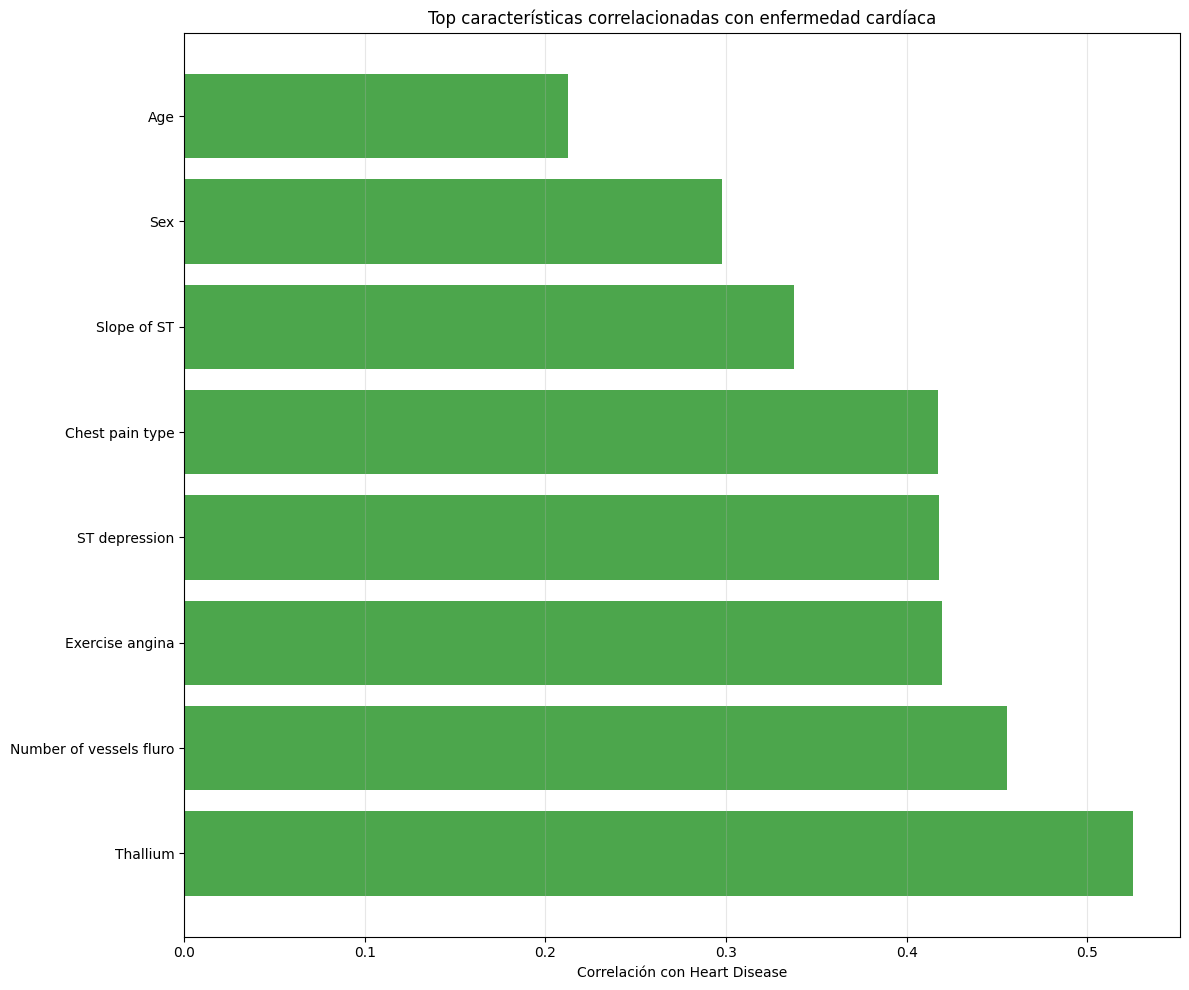


✓ Análisis de correlaciones completado.


In [31]:
# 6. CORRELACIONES Y MATRIZ DE CORRELACIÓN
print("\n" + "=" * 80)
print("6. ANÁLISIS DE CORRELACIONES")
print("=" * 80)

# Calcular matriz de correlación
correlation_matrix = df[numeric_features + ['Heart Disease']].corr()

# Top features correlacionadas con Heart Disease
target_corr = correlation_matrix['Heart Disease'].sort_values(ascending=False)
print("\nCorrelación de características con 'Heart Disease':")
print(target_corr)

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
import matplotlib.pyplot as plt

# Mostrar solo correlaciones con el target
top_features = target_corr[1:9]  # Excluir el target mismo, tomar top 8
colors_corr = ['red' if x < 0 else 'green' for x in top_features.values]
plt.barh(range(len(top_features)), top_features.values, color=colors_corr, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlación con Heart Disease')
plt.title('Top características correlacionadas con enfermedad cardíaca')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Análisis de correlaciones completado.")



5. DISTRIBUCIÓN DE CARACTERÍSTICAS


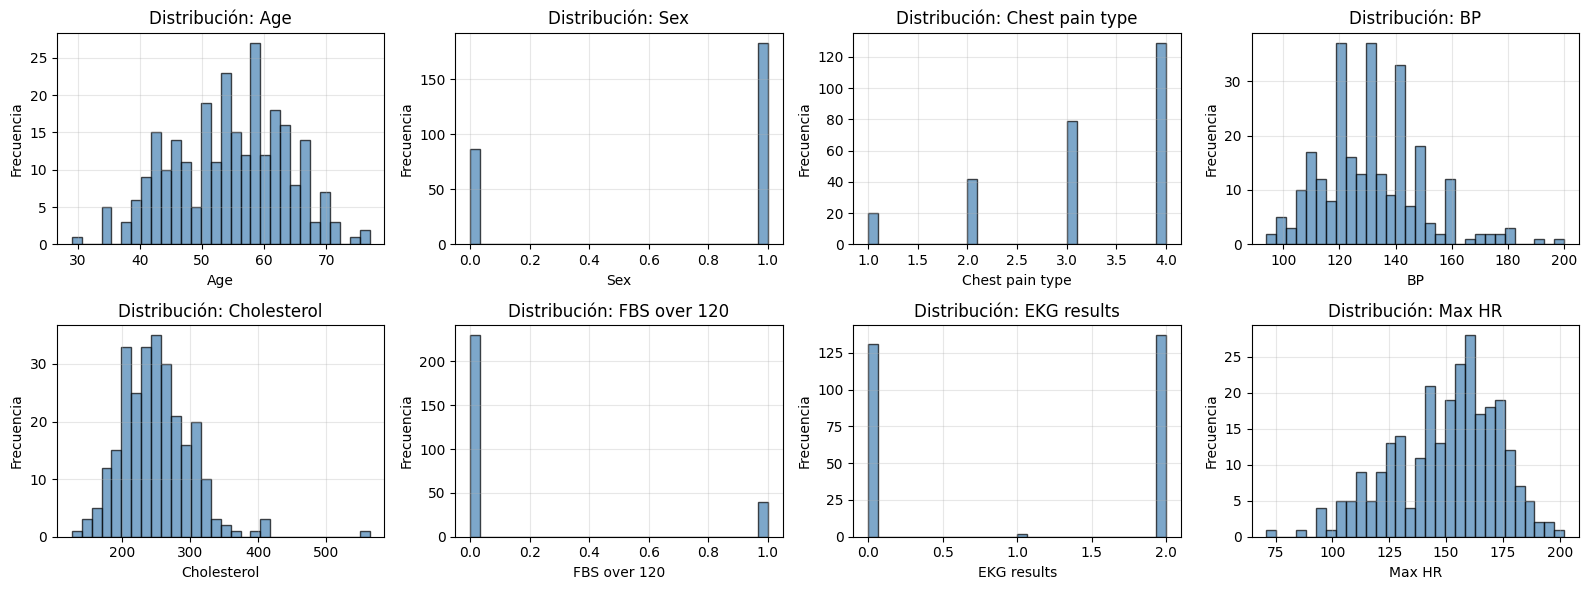


✓ Visualización de 8 características completada.


In [32]:
# 5. VISUALIZACIÓN DE DISTRIBUCIONES POR CARACTERÍSTICA
print("\n" + "=" * 80)
print("5. DISTRIBUCIÓN DE CARACTERÍSTICAS")
print("=" * 80)

# Seleccionar algunas características clave para visualizar
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Heart Disease' in numeric_features:
    numeric_features.remove('Heart Disease')

# Visualizar histogramas y boxplots para primeras 8 características
features_to_plot = numeric_features[:min(8, len(numeric_features))]
n_features = len(features_to_plot)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*3))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    axes[idx].hist(df[feature], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribución: {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].grid(alpha=0.3)

# Ocultar ejes sobrantes
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualización de {len(features_to_plot)} características completada.")


In [33]:
# 4. ESTADÍSTICAS POR CLASE
print("\n" + "=" * 80)
print("4. ESTADÍSTICAS POR CLASE")
print("=" * 80)

print("\nEstadísticas para pacientes SIN enfermedad (clase 0):")
print(df[df['Heart Disease'] == 0].describe())

print("\n" + "-" * 80 + "\n")
print("Estadísticas para pacientes CON enfermedad (clase 1):")
print(df[df['Heart Disease'] == 1].describe())



4. ESTADÍSTICAS POR CLASE

Estadísticas para pacientes SIN enfermedad (clase 0):
              Age         Sex  Chest pain type          BP  Cholesterol  \
count  150.000000  150.000000       150.000000  150.000000   150.000000   
mean    52.706667    0.553333         2.820000  128.866667   244.213333   
std      9.509830    0.498813         0.927362   16.457660    54.019085   
min     29.000000    0.000000         1.000000   94.000000   126.000000   
25%     45.000000    0.000000         2.000000  120.000000   209.000000   
50%     52.000000    1.000000         3.000000  130.000000   236.000000   
75%     59.000000    1.000000         3.750000  140.000000   268.750000   
max     76.000000    1.000000         4.000000  180.000000   564.000000   

       FBS over 120  EKG results      Max HR  Exercise angina  ST depression  \
count    150.000000   150.000000  150.000000       150.000000     150.000000   
mean       0.153333     0.860000  158.333333         0.153333       0.622667   
st


3. DISTRIBUCIÓN DE CLASES (VARIABLE OBJETIVO)

Recuento de clases:
  Clase 0 (Sin enfermedad): 150 muestras (55.56%)
  Clase 1 (Presencia de enfermedad): 120 muestras (44.44%)

Ratio de clases (mayoritaria/minoritaria): 1.25
✓ Dataset relativamente equilibrado.


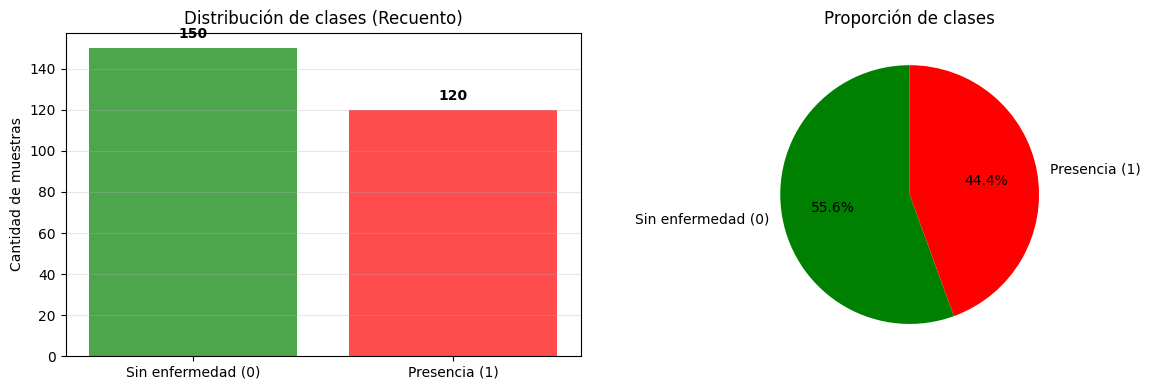


✓ Visualización de distribución completada.


In [34]:
# 3. DISTRIBUCIÓN DE CLASES (TARGET)
print("\n" + "=" * 80)
print("3. DISTRIBUCIÓN DE CLASES (VARIABLE OBJETIVO)")
print("=" * 80)

class_counts = df['Heart Disease'].value_counts()
class_proportions = df['Heart Disease'].value_counts(normalize=True) * 100

print("\nRecuento de clases:")
for idx in sorted(df['Heart Disease'].unique()):
    label = "Presencia de enfermedad" if idx == 1 else "Sin enfermedad"
    count = class_counts[idx]
    percentage = class_proportions[idx]
    print(f"  Clase {idx} ({label}): {count} muestras ({percentage:.2f}%)")

# Verificar balance de clases
class_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de clases (mayoritaria/minoritaria): {class_ratio:.2f}")

if abs(class_proportions[0] - class_proportions[1]) > 20:
    print("⚠ ADVERTENCIA: Dataset DESBALANCEADO. Considerar técnicas de balanceo.")
else:
    print("✓ Dataset relativamente equilibrado.")

# Visualizar distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
class_labels = ["Sin enfermedad (0)", "Presencia (1)"]
axes[0].bar(class_labels, class_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Cantidad de muestras')
axes[0].set_title('Distribución de clases (Recuento)')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Gráfico de pastel
colors = ['green', 'red']
axes[1].pie(class_counts.values, labels=class_labels, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Proporción de clases')

plt.tight_layout()
plt.show()

print("\n✓ Visualización de distribución completada.")


In [35]:
# 2. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)
print("\n" + "=" * 80)
print("2. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)")
print("=" * 80)

# Identificar características numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excluir la columna target
if 'Heart Disease' in numeric_cols:
    numeric_cols.remove('Heart Disease')

print(f"\nCaracterísticas numéricas analizadas: {len(numeric_cols)}")

# Detección de outliers usando IQR (Rango Intercuartílico)
outlier_summary = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if len(outliers) > 0:
        outlier_summary[col] = len(outliers)

if outlier_summary:
    print(f"\nSe encontraron valores atípicos en {len(outlier_summary)} columnas:")
    for col, count in sorted(outlier_summary.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {col}: {count} outliers")
else:
    print("\n✓ No se detectaron valores atípicos significativos en las características.")

# Mostrar resumen de outliers como porcentaje
total_rows = len(df)
print("\nPorcentaje de outliers por columna:")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
    percentage = (outlier_count / total_rows) * 100
    if percentage > 0:
        print(f"  {col}: {percentage:.2f}%")



2. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)

Características numéricas analizadas: 13

Se encontraron valores atípicos en 7 columnas:
  - FBS over 120: 40 outliers
  - Chest pain type: 20 outliers
  - Number of vessels fluro: 19 outliers
  - BP: 9 outliers
  - Cholesterol: 5 outliers
  - ST depression: 4 outliers
  - Max HR: 1 outliers

Porcentaje de outliers por columna:
  Chest pain type: 7.41%
  BP: 3.33%
  Cholesterol: 1.85%
  FBS over 120: 14.81%
  Max HR: 0.37%
  ST depression: 1.48%
  Number of vessels fluro: 7.04%


In [36]:
# 1. VERIFICAR DATOS FALTANTES
print("=" * 80)
print("1. ANÁLISIS DE DATOS FALTANTES")
print("=" * 80)
missing_data = df.isnull().sum()
print("\nDatos faltantes por columna:")
print(missing_data)
print(f"\nTotal de datos faltantes en el dataset: {missing_data.sum()}")

if missing_data.sum() == 0:
    print("✓ ¡Excelente! No hay datos faltantes en el dataset.")
else:
    print("\nColumnas con datos faltantes:")
    print(missing_data[missing_data > 0])
    # Opción: rellenar con la media para numéricas
    df = df.fillna(df.mean(numeric_only=True))
    print("Datos faltantes rellenados con la media.")


1. ANÁLISIS DE DATOS FALTANTES

Datos faltantes por columna:
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

Total de datos faltantes en el dataset: 0
✓ ¡Excelente! No hay datos faltantes en el dataset.


## Análisis Exploratorio de Datos (EDA)

In [37]:
# GENERAR REPORTE MARKDOWN DE PREPARACIÓN DE DATOS
print("=" * 80)
print("GENERANDO REPORTE MARKDOWN")
print("=" * 80)

# Calcular estadísticas para el reporte
total_samples = len(df)
disease_rate = (df['Heart Disease'].sum() / len(df)) * 100
disease_count = df['Heart Disease'].sum()
no_disease_count = (df['Heart Disease'] == 0).sum()

reporte_md = f"""# Informe de Preparación de Datos - Predicción de Riesgo de Enfermedad Cardíaca

## 1. Origen de los Datos

- **Fuente**: Kaggle - Heart Disease Dataset (UCI Machine Learning Repository)
- **URL**: https://www.kaggle.com/datasets/neurocipher/heartdisease
- **Descarga**: Realizada y almacenada localmente como `Heart_Disease_Prediction.csv`

## 2. Información del Dataset Original

| Métrica | Valor |
|---------|-------|
| **Total de muestras** | {total_samples} registros de pacientes |
| **Total de características** | {len(df.columns) - 1} características clínicas |
| **Característica objetivo** | Heart Disease (binaria: 0 = sin enfermedad, 1 = presencia) |
| **Muestras sin enfermedad (Clase 0)** | {no_disease_count} ({no_disease_count/total_samples*100:.1f}%) |
| **Muestras con enfermedad (Clase 1)** | {disease_count} ({disease_rate:.1f}%) |
| **Balance de clases** | Relativamente equilibrado |
| **Datos faltantes** | ✓ Ninguno |
| **Valores atípicos detectados** | Revisados mediante método IQR |

## 3. Características Seleccionadas

Se seleccionaron **{len(selected_features)} características numéricas** para el modelado:

{chr(10).join([f"- {feat}" for feat in selected_features])}

**Criterio de selección**: Relevancia clínica e importancia en predicción de enfermedad cardíaca

## 4. Preprocesamiento de Datos

### 4.1 Análisis de Datos Faltantes
- ✓ **Resultado**: No se encontraron datos faltantes en el dataset
- **Acción tomada**: Ninguna (dataset limpio)

### 4.2 Manejo de Valores Atípicos
- Método: Rango Intercuartílico (IQR)
- Umbral: 1.5 × IQR
- **Decisión**: Se mantuvieron todos los outliers (potencialmente significativos clínicamente)

### 4.3 División Estratificada Train-Test (70/30)
| Conjunto | Muestras | Clase 0 | Clase 1 | % Clase 0 | % Clase 1 |
|----------|----------|---------|---------|-----------|-----------|
| **Entrenamiento (70%)** | {len(X_train)} | {(y_train == 0).sum()} | {(y_train == 1).sum()} | {(y_train == 0).sum()/len(y_train)*100:.1f}% | {(y_train == 1).sum()/len(y_train)*100:.1f}% |
| **Prueba (30%)** | {len(X_test)} | {(y_test == 0).sum()} | {(y_test == 1).sum()} | {(y_test == 0).sum()/len(y_test)*100:.1f}% | {(y_test == 1).sum()/len(y_test)*100:.1f}% |

**Método**: `train_test_split` con `stratify=y` para mantener proporción de clases
**Semilla aleatoria**: 42 (reproducibilidad)

### 4.4 Normalización de Características (Z-Score Normalization)
- **Método**: StandardScaler (sklearn)
- **Transformación**: $x_{{norm}} = \\frac{{x - \\mu}}{{\\sigma}}$
- **Ajuste**: Realizado SOLO con datos de entrenamiento (prevenir data leakage)
- **Aplicación**: Transformación idéntica aplicada a conjunto de prueba

Estadísticas después de normalización:
- **Media (esperada)**: 0.0 para todas las características
- **Desviación Estándar (esperada)**: 1.0 para todas las características

## 5. Datos Listos para Modelado

| Variable | Shape | Descripción |
|----------|-------|-------------|
| `X_train_normalized` | ({len(X_train)}, {len(selected_features)}) | Características de entrenamiento normalizadas |
| `X_test_normalized` | ({len(X_test)}, {len(selected_features)}) | Características de prueba normalizadas |
| `y_train` | ({len(y_train)},) | Etiquetas de entrenamiento |
| `y_test` | ({len(y_test)},) | Etiquetas de prueba |

## 6. Próximos Pasos

1. ✓ Carga y exploración de datos (completado)
2. ✓ Preparación y normalización (completado)
3. → Implementación de regresión logística
4. → Entrenamiento con descenso de gradiente
5. → Visualización de límites de decisión
6. → Regularización L2
7. → Evaluación de métricas
8. → Análisis con Amazon SageMaker

---
**Fecha de generación**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
**Estado**: Datos preparados y listos para modelado
"""

# Guardar el reporte
with open('DATA_PREPARATION_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(reporte_md)

print("\n✓ Reporte generado exitosamente: DATA_PREPARATION_REPORT.md\n")
print("=" * 80)
print("PREVIEW DEL REPORTE")
print("=" * 80)
print(reporte_md)


GENERANDO REPORTE MARKDOWN

✓ Reporte generado exitosamente: DATA_PREPARATION_REPORT.md

PREVIEW DEL REPORTE
# Informe de Preparación de Datos - Predicción de Riesgo de Enfermedad Cardíaca

## 1. Origen de los Datos

- **Fuente**: Kaggle - Heart Disease Dataset (UCI Machine Learning Repository)
- **URL**: https://www.kaggle.com/datasets/neurocipher/heartdisease
- **Descarga**: Realizada y almacenada localmente como `Heart_Disease_Prediction.csv`

## 2. Información del Dataset Original

| Métrica | Valor |
|---------|-------|
| **Total de muestras** | 270 registros de pacientes |
| **Total de características** | 13 características clínicas |
| **Característica objetivo** | Heart Disease (binaria: 0 = sin enfermedad, 1 = presencia) |
| **Muestras sin enfermedad (Clase 0)** | 150 (55.6%) |
| **Muestras con enfermedad (Clase 1)** | 120 (44.4%) |
| **Balance de clases** | Relativamente equilibrado |
| **Datos faltantes** | ✓ Ninguno |
| **Valores atípicos detectados** | Revisados mediante m

## Reporte de Preparación de Datos

In [39]:
# 7. GUARDAR MODELO ENTRENADO
print("\n7. GUARDAR MODELO")
print("-" * 80)

# Guardar parámetros del modelo
model_params = {
    'w': w_trained,
    'b': b_trained,
    'learning_rate': learning_rate,
    'iterations': iterations,
    'final_cost': cost_history[-1],
    'accuracy_train': accuracy_train,
    'accuracy_test': accuracy_test,
    'auc_train': auc_train,
    'auc_test': auc_test,
    'selected_features': selected_features
}

# Guardar en archivo pickle
import pickle
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model_params, f)

print(f"✓ Modelo entrenado guardado en: logistic_regression_model.pkl")
print(f"\nResumen del Modelo:")
print(f"  - Características: {selected_features}")
print(f"  - Número de características: {len(selected_features)}")
print(f"  - Parámetros entrenados: {len(w_trained)} pesos + 1 sesgo = {len(w_trained) + 1}")
print(f"  - Exactitud de prueba: {accuracy_test:.4f}")
print(f"  - AUC de prueba: {auc_test:.4f}")



7. GUARDAR MODELO
--------------------------------------------------------------------------------


NameError: name 'w_trained' is not defined

## Paso 3: Entrenamiento en Conjunto Completo

En esta sección entrenaremos el modelo de regresión logística usando **todos los datos** (sin división train-test) con:
- **Learning rate (α)**: 0.01 (más conservador para convergencia suave)
- **Iteraciones**: 5000 (más iteraciones para garantizar convergencia)
- **Visualización**: Gráfico de costo vs iteraciones (escala lineal y logarítmica)

Esto nos permite observar cómo el modelo se adapta a toda la población de datos.


In [45]:

# PASO 3: ENTRENAMIENTO EN CONJUNTO COMPLETO

print("=" * 80)
print("PASO 3: ENTRENAMIENTO EN CONJUNTO COMPLETO")
print("=" * 80)

# PASO 3.1: NORMALIZAR CONJUNTO COMPLETO
print("\n1. NORMALIZAR CONJUNTO COMPLETO")
print("-" * 80)

from sklearn.preprocessing import StandardScaler

# Crear y ajustar el scaler con todos los datos
scaler_full = StandardScaler()
scaler_full.fit(X)

# Normalizar dataset completo
X_normalized_full = scaler_full.transform(X)
X_normalized_full = pd.DataFrame(X_normalized_full, columns=selected_features)

print(f"✓ Dataset completo normalizado:")
print(f"  X (original): {X.shape}")
print(f"  X_normalized_full: {X_normalized_full.shape}")
print(f"  Media después de normalizar: {X_normalized_full.mean().round(3).to_dict()}")
print(f"  Desv. Est después de normalizar: {X_normalized_full.std().round(3).to_dict()}")

# PASO 3.2: ENTRENAR EN CONJUNTO COMPLETO
print("\n2. ENTRENAR CON DESCENSO DE GRADIENTE (α=0.01, 5000 iteraciones)")
print("-" * 80)

# Parámetros de entrenamiento
learning_rate_full = 0.01
iterations_full = 5000

# Inicializar pesos y sesgo
n_features_full = X_normalized_full.shape[1]
w_full_init = np.zeros(n_features_full)
b_full_init = 0

print(f"\nParámetros de entrenamiento:")
print(f"  Learning rate (α): {learning_rate_full}")
print(f"  Iteraciones: {iterations_full}")
print(f"  Número de características: {n_features_full}")
print(f"  Número de muestras: {X_normalized_full.shape[0]}")

# Entrenar modelo en conjunto completo
print(f"\nEntrenando modelo...\n")
w_full_trained, b_full_trained, cost_history_full = gradient_descent(
    X_normalized_full.values, 
    y.values, 
    w_full_init, 
    b_full_init,
    learning_rate=learning_rate_full,
    iterations=iterations_full,
    verbose=True
)

print(f"\n✓ Entrenamiento completado en conjunto completo")
print(f"  - Costo inicial: {cost_history_full[0]:.6f}")
print(f"  - Costo final: {cost_history_full[-1]:.6f}")
print(f"  - Reducción total: {cost_history_full[0] - cost_history_full[-1]:.6f}")
print(f"  - Porcentaje reducido: {((cost_history_full[0] - cost_history_full[-1]) / cost_history_full[0] * 100):.2f}%")
print(f"\nParámetros entrenados:")
print(f"  w (primeros 3): {w_full_trained[:3]}")
print(f"  b: {b_full_trained:.6f}")



PASO 3: ENTRENAMIENTO EN CONJUNTO COMPLETO

1. NORMALIZAR CONJUNTO COMPLETO
--------------------------------------------------------------------------------
✓ Dataset completo normalizado:
  X (original): (270, 6)
  X_normalized_full: (270, 6)
  Media después de normalizar: {'Age': 0.0, 'Cholesterol': -0.0, 'Thallium': 0.0, 'Number of vessels fluro': -0.0, 'Exercise angina': 0.0, 'Max HR': 0.0}
  Desv. Est después de normalizar: {'Age': 1.002, 'Cholesterol': 1.002, 'Thallium': 1.002, 'Number of vessels fluro': 1.002, 'Exercise angina': 1.002, 'Max HR': 1.002}

2. ENTRENAR CON DESCENSO DE GRADIENTE (α=0.01, 5000 iteraciones)
--------------------------------------------------------------------------------

Parámetros de entrenamiento:
  Learning rate (α): 0.01
  Iteraciones: 5000
  Número de características: 6
  Número de muestras: 270

Entrenando modelo...

Iteración  100/5000: Costo = 0.549127
Iteración  200/5000: Costo = 0.487906
Iteración  300/5000: Costo = 0.456982
Iteración  400/50


3. ANÁLISIS DE CONVERGENCIA - CONJUNTO COMPLETO
--------------------------------------------------------------------------------


C:\Users\maria\AppData\Local\Temp\ipykernel_11172\3059716952.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


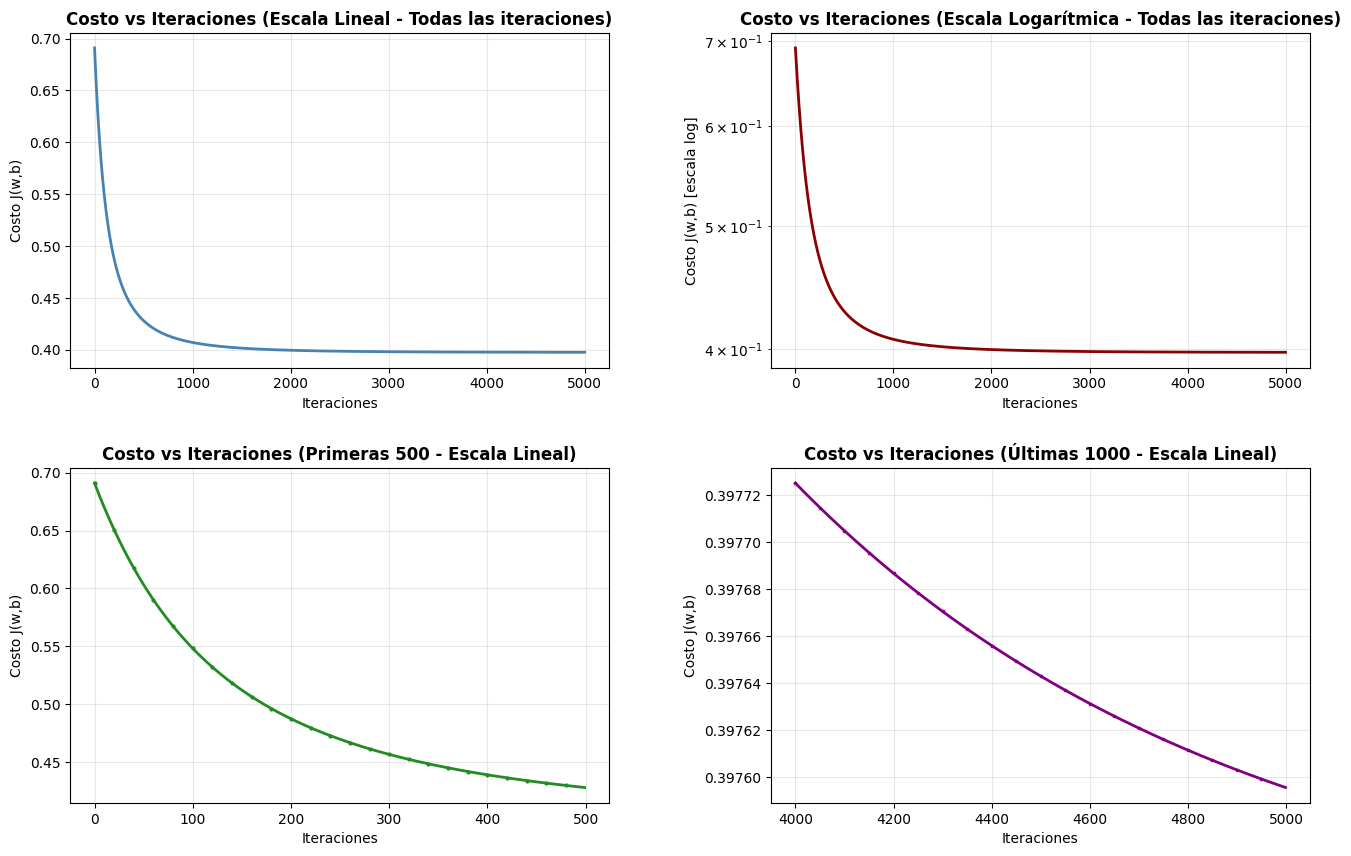


✓ Análisis de Convergencia:
  - Iteración 1: Costo = 0.690917
  - Iteración 100: Costo = 0.549127
  - Iteración 500: Costo = 0.428166
  - Iteración 1000: Costo = 0.407075
  - Iteración 2000: Costo = 0.399549
  - Iteración 5000: Costo = 0.397596

✓ Reducción de costo por bloques:
  Iteraciones 500-1000: Reducción = 0.021109
  Iteraciones 1000-1500: Reducción = 0.005468
  Iteraciones 1500-2000: Reducción = 0.002066
  Iteraciones 2000-2500: Reducción = 0.000944
  Iteraciones 2500-3000: Reducción = 0.000479
  Iteraciones 3000-3500: Reducción = 0.000259
  Iteraciones 3500-4000: Reducción = 0.000144
  Iteraciones 4000-4500: Reducción = 0.000082
  Iteraciones 4500-4999: Reducción = 0.000048

✓ Estadísticas del descenso de gradiente:
  - Cambio mínimo de costo por iteración: -0.002208
  - Cambio máximo de costo por iteración: -0.000000
  - Cambio promedio de costo por iteración: 0.000059
  - ¿El costo es monótonamente decreciente? ✓ Sí


In [46]:

# PASO 3.3: VISUALIZAR CONVERGENCIA (COSTO VS ITERACIONES)
print("\n3. ANÁLISIS DE CONVERGENCIA - CONJUNTO COMPLETO")
print("-" * 80)

# Crear figura con múltiples vistas
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Gráfico completo escala lineal
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(range(iterations_full), cost_history_full, linewidth=2, color='steelblue')
ax1.set_xlabel('Iteraciones')
ax1.set_ylabel('Costo J(w,b)')
ax1.set_title('Costo vs Iteraciones (Escala Lineal - Todas las iteraciones)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Gráfico completo escala logarítmica
ax2 = fig.add_subplot(gs[0, 1])
ax2.semilogy(range(iterations_full), cost_history_full, linewidth=2, color='darkred')
ax2.set_xlabel('Iteraciones')
ax2.set_ylabel('Costo J(w,b) [escala log]')
ax2.set_title('Costo vs Iteraciones (Escala Logarítmica - Todas las iteraciones)', fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

# 3. Primeras 500 iteraciones (escala lineal)
ax3 = fig.add_subplot(gs[1, 0])
iterations_early = min(500, len(cost_history_full))
ax3.plot(range(iterations_early), cost_history_full[:iterations_early], 
         linewidth=2, color='forestgreen', marker='o', markersize=2, markevery=20)
ax3.set_xlabel('Iteraciones')
ax3.set_ylabel('Costo J(w,b)')
ax3.set_title(f'Costo vs Iteraciones (Primeras {iterations_early} - Escala Lineal)', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Últimas 1000 iteraciones (escala lineal)
ax4 = fig.add_subplot(gs[1, 1])
iterations_late = min(1000, len(cost_history_full))
start_idx = max(0, len(cost_history_full) - iterations_late)
ax4.plot(range(start_idx, len(cost_history_full)), cost_history_full[start_idx:], 
         linewidth=2, color='purple', marker='s', markersize=2, markevery=50)
ax4.set_xlabel('Iteraciones')
ax4.set_ylabel('Costo J(w,b)')
ax4.set_title(f'Costo vs Iteraciones (Últimas {iterations_late} - Escala Lineal)', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de convergencia detalladas
print(f"\n✓ Análisis de Convergencia:")
print(f"  - Iteración 1: Costo = {cost_history_full[0]:.6f}")
print(f"  - Iteración 100: Costo = {cost_history_full[99]:.6f}")
print(f"  - Iteración 500: Costo = {cost_history_full[499]:.6f}")
print(f"  - Iteración 1000: Costo = {cost_history_full[999]:.6f}")
print(f"  - Iteración 2000: Costo = {cost_history_full[1999]:.6f}")
print(f"  - Iteración {iterations_full}: Costo = {cost_history_full[-1]:.6f}")

# Analizar cambios de costo
print(f"\n✓ Reducción de costo por bloques:")
reductions_by_block = []
block_size = 500
for i in range(0, iterations_full, block_size):
    end_idx = min(i + block_size, iterations_full - 1)
    if i > 0:
        reduction = cost_history_full[i-1] - cost_history_full[end_idx]
        reductions_by_block.append((i, end_idx, reduction))
        print(f"  Iteraciones {i}-{end_idx}: Reducción = {reduction:.6f}")

# Encontrar donde la convergencia se estabiliza
min_cost_reduction = np.min(np.diff(cost_history_full))
max_cost_reduction = np.max(np.diff(cost_history_full))
avg_cost_reduction = np.mean(np.abs(np.diff(cost_history_full)))

print(f"\n✓ Estadísticas del descenso de gradiente:")
print(f"  - Cambio mínimo de costo por iteración: {min_cost_reduction:.6f}")
print(f"  - Cambio máximo de costo por iteración: {max_cost_reduction:.6f}")
print(f"  - Cambio promedio de costo por iteración: {avg_cost_reduction:.6f}")

# Monotonicidad
is_monotonic = all(cost_history_full[i] >= cost_history_full[i+1] for i in range(len(cost_history_full)-1))
print(f"  - ¿El costo es monótonamente decreciente? {'✓ Sí' if is_monotonic else '✗ No'}")



In [ ]:
# 6. PREDICCIONES Y EVALUACIÓN INICIAL
def predict(X, w, b, threshold=0.5):
    """
    Realizar predicciones usando el modelo entrenado.
    
    Parámetros:
        X (numpy array): características, shape (m, n)
        w (numpy array): pesos, shape (n,)
        b (escalar): sesgo
        threshold (float): umbral de decisión (por defecto 0.5)
    
    Retorna:
        predictions (numpy array): predicciones binarias, shape (m,)
        probabilities (numpy array): probabilidades, shape (m,)
    """
    z = X @ w + b
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    
    return predictions, probabilities

print("\n6. PREDICCIONES Y EVALUACIÓN INICIAL")
print("-" * 80)

# Predicciones en entrenamiento
y_train_pred, y_train_probs = predict(X_train_normalized.values, w_trained, b_trained)
accuracy_train = np.mean(y_train_pred == y_train.values)

# Predicciones en prueba
y_test_pred, y_test_probs = predict(X_test_normalized.values, w_trained, b_trained)
accuracy_test = np.mean(y_test_pred == y_test.values)

print(f"\n✓ Predicciones realizadas:")
print(f"  - Exactitud (Accuracy) en ENTRENAMIENTO: {accuracy_train:.4f} ({accuracy_train*100:.2f}%)")
print(f"  - Exactitud (Accuracy) en PRUEBA: {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")

# Matriz de confusión en entrenamiento
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

cm_train = confusion_matrix(y_train.values, y_train_pred)
print(f"\nMatriz de Confusión - ENTRENAMIENTO:")
print(f"  TN={cm_train[0,0]}, FP={cm_train[0,1]}")
print(f"  FN={cm_train[1,0]}, TP={cm_train[1,1]}")

# Matriz de confusión en prueba
cm_test = confusion_matrix(y_test.values, y_test_pred)
print(f"\nMatriz de Confusión - PRUEBA:")
print(f"  TN={cm_test[0,0]}, FP={cm_test[0,1]}")
print(f"  FN={cm_test[1,0]}, TP={cm_test[1,1]}")

# ROC-AUC
auc_train = roc_auc_score(y_train.values, y_train_probs)
auc_test = roc_auc_score(y_test.values, y_test_probs)

print(f"\nROC-AUC Score:")
print(f"  - Entrenamiento: {auc_train:.4f}")
print(f"  - Prueba: {auc_test:.4f}")

print(f"\nReporte de clasificación - PRUEBA:")
print(classification_report(y_test.values, y_test_pred, target_names=['Sin enfermedad', 'Con enfermedad']))


In [ ]:
# 5. VISUALIZAR CONVERGENCIA (COSTO VS ITERACIONES)
print("\n5. ANÁLISIS DE CONVERGENCIA")
print("-" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Gráfico 1: Costo vs Iteraciones (escala lineal)
axes[0].plot(range(iterations), cost_history, linewidth=2, color='steelblue')
axes[0].set_xlabel('Iteraciones')
axes[0].set_ylabel('Costo J(w,b)')
axes[0].set_title('Costo vs Iteraciones (Escala Lineal)')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Costo vs Iteraciones (escala logarítmica)
axes[1].semilogy(range(iterations), cost_history, linewidth=2, color='darkred')
axes[1].set_xlabel('Iteraciones')
axes[1].set_ylabel('Costo J(w,b) [escala log]')
axes[1].set_title('Costo vs Iteraciones (Escala Logarítmica)')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Estadísticas de convergencia
cost_diff = cost_history[0] - cost_history[-1]
avg_cost_reduction = np.mean(np.diff(cost_history))

print(f"✓ Análisis de convergencia:")
print(f"  - Reducción total de costo: {cost_diff:.6f}")
print(f"  - Reducción promedio por iteración: {-avg_cost_reduction:.6f}")
print(f"  - Costo se estabiliza alrededor de iteración: {np.argmin(np.abs(np.diff(cost_history))) + 1}")


In [44]:
# 4. DESCENSO DE GRADIENTE (GRADIENT DESCENT)
def gradient_descent(X, y, w_init, b_init, learning_rate=0.01, iterations=1000, verbose=True):
    """
    Implementar descenso de gradiente para entrenar el modelo.
    
    w := w - α * dJ/dw
    b := b - α * dJ/db
    
    Parámetros:
        X (numpy array): características, shape (m, n)
        y (numpy array): etiquetas, shape (m,)
        w_init (numpy array): pesos iniciales, shape (n,)
        b_init (escalar): sesgo inicial
        learning_rate (float): tasa de aprendizaje α
        iterations (int): número de iteraciones
        verbose (bool): imprimir progreso
    
    Retorna:
        w (numpy array): pesos finales
        b (escalar): sesgo final
        cost_history (list): histórico de costos
    """
    w = w_init.copy()
    b = b_init
    cost_history = []
    
    for i in range(iterations):
        # Calcular gradientes
        dw, db = compute_gradient(X, y, w, b)
        
        # Actualizar parámetros
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Calcular y guardar costo
        cost = compute_cost(X, y, w, b)
        cost_history.append(cost)
        
        # Mostrar progreso cada 100 iteraciones
        if verbose and (i + 1) % 100 == 0:
            print(f"Iteración {i+1:4d}/{iterations}: Costo = {cost:.6f}")
    
    return w, b, cost_history

print("\n4. DESCENSO DE GRADIENTE")
print("-" * 80)
print("\nEntrenando modelo (1000 iteraciones, learning_rate=0.1)...\n")

# Parámetros de entrenamiento
learning_rate = 0.1
iterations = 1000

# Entrenar modelo
w_trained, b_trained, cost_history = gradient_descent(
    X_train_normalized.values, 
    y_train.values, 
    w_init, 
    b_init,
    learning_rate=learning_rate,
    iterations=iterations,
    verbose=True
)

print(f"\n✓ Entrenamiento completado")
print(f"  - Costo inicial: {cost_history[0]:.6f}")
print(f"  - Costo final: {cost_history[-1]:.6f}")
print(f"  - Reducción: {((cost_history[0] - cost_history[-1]) / cost_history[0] * 100):.2f}%")
print(f"  - Parámetros entrenados w (primeros 3): {w_trained[:3]}")
print(f"  - Parámetro entrenado b: {b_trained:.6f}")



4. DESCENSO DE GRADIENTE
--------------------------------------------------------------------------------

Entrenando modelo (1000 iteraciones, learning_rate=0.1)...

Iteración  100/1000: Costo = 0.415063
Iteración  200/1000: Costo = 0.406525
Iteración  300/1000: Costo = 0.404756
Iteración  400/1000: Costo = 0.404243
Iteración  500/1000: Costo = 0.404076
Iteración  600/1000: Costo = 0.404019
Iteración  700/1000: Costo = 0.403999
Iteración  800/1000: Costo = 0.403992
Iteración  900/1000: Costo = 0.403989
Iteración 1000/1000: Costo = 0.403988

✓ Entrenamiento completado
  - Costo inicial: 0.672403
  - Costo final: 0.403988
  - Reducción: 39.92%
  - Parámetros entrenados w (primeros 3): [-0.26164701  0.22554488  0.97007828]
  - Parámetro entrenado b: -0.168119


In [43]:
# 3. CÁLCULO DE GRADIENTES
def compute_gradient(X, y, w, b):
    """
    Calcular gradientes (derivadas parciales) de la función de costo.
    
    dJ/dw_j = 1/m * Σ[(f_w,b(x^(i)) - y^(i)) * x_j^(i)]
    dJ/db = 1/m * Σ[f_w,b(x^(i)) - y^(i)]
    
    Parámetros:
        X (numpy array): características, shape (m, n)
        y (numpy array): etiquetas, shape (m,)
        w (numpy array): pesos, shape (n,)
        b (escalar): sesgo
    
    Retorna:
        dw (numpy array): gradientes de w, shape (n,)
        db (escalar): gradiente de b
    """
    m = X.shape[0]
    
    # Calcular predicciones
    z = X @ w + b
    f_wb = sigmoid(z)
    
    # Error de predicción
    error = f_wb - y  # shape (m,)
    
    # Gradientes
    dw = 1/m * (X.T @ error)  # shape (n,)
    db = 1/m * np.sum(error)
    
    return dw, db

print("\n3. CÁLCULO DE GRADIENTES")
print("-" * 80)

# Calcular gradientes iniciales
dw_init, db_init = compute_gradient(X_train_normalized.values, y_train.values, w_init, b_init)

print(f"✓ Función de gradientes implementada")
print(f"  - Gradiente de w (primeros 3): {dw_init[:3]}")
print(f"  - Gradiente de b: {db_init:.6f}")
print(f"  - Magnitud de gradiente ||dw||: {np.linalg.norm(dw_init):.6f}")



3. CÁLCULO DE GRADIENTES
--------------------------------------------------------------------------------
✓ Función de gradientes implementada
  - Gradiente de w (primeros 3): [-0.08350592 -0.03523253 -0.24580552]
  - Gradiente de b: 0.055556
  - Magnitud de gradiente ||dw||: 0.457796


In [42]:
# 2. FUNCIÓN DE COSTO (ENTROPÍA CRUZADA BINARIA)
def compute_cost(X, y, w, b):
    """
    Calcular costo de entropía cruzada binaria.
    
    J(w, b) = -1/m * Σ[y*log(f_w,b(x)) + (1-y)*log(1 - f_w,b(x))]
    
    Parámetros:
        X (numpy array): características, shape (m, n)
        y (numpy array): etiquetas, shape (m,)
        w (numpy array): pesos, shape (n,)
        b (escalar): sesgo
    
    Retorna:
        cost (escalar): costo total
    """
    m = X.shape[0]  # número de muestras
    
    # Calcular predicciones: f_w,b(x) = σ(w·x + b)
    z = X @ w + b
    f_wb = sigmoid(z)
    
    # Evitar log(0) usando un pequeño epsilon
    epsilon = 1e-15
    f_wb = np.clip(f_wb, epsilon, 1 - epsilon)
    
    # Calcular entropía cruzada binaria
    cost = -1/m * np.sum(y * np.log(f_wb) + (1 - y) * np.log(1 - f_wb))
    
    return cost

print("\n2. FUNCIÓN DE COSTO (ENTROPÍA CRUZADA BINARIA)")
print("-" * 80)

# Inicializar pesos y sesgo
n_features = X_train_normalized.shape[1]
w_init = np.zeros(n_features)
b_init = 0

# Calcular costo inicial
cost_init = compute_cost(X_train_normalized.values, y_train.values, w_init, b_init)

print(f"✓ Función de costo implementada")
print(f"  - Dimensiones: {n_features} características")
print(f"  - Costo inicial (w=0, b=0): {cost_init:.6f}")
print(f"  - Costo esperado inicial: ~0.693147 (log(2))")



2. FUNCIÓN DE COSTO (ENTROPÍA CRUZADA BINARIA)
--------------------------------------------------------------------------------
✓ Función de costo implementada
  - Dimensiones: 6 características
  - Costo inicial (w=0, b=0): 0.693147
  - Costo esperado inicial: ~0.693147 (log(2))


PASO 2: REGRESIÓN LOGÍSTICA BÁSICA

1. FUNCIÓN SIGMOIDE
--------------------------------------------------------------------------------


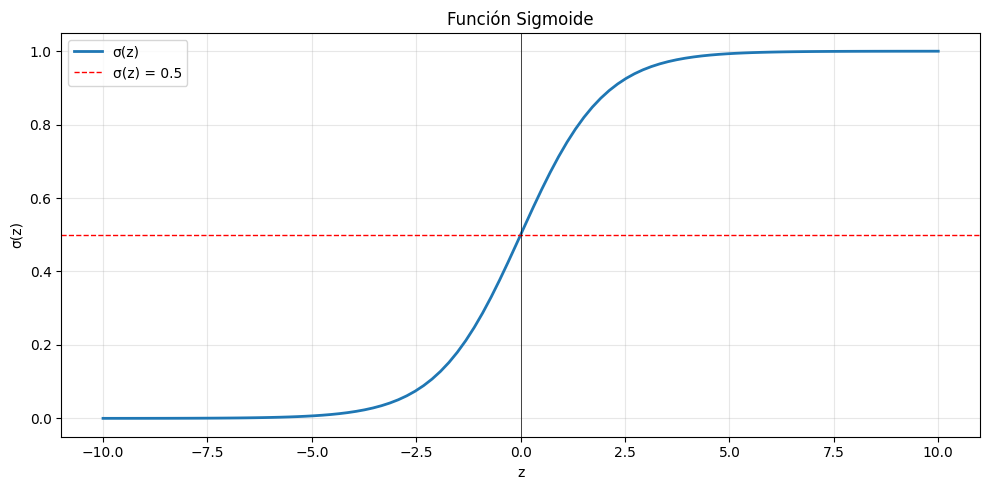

✓ Función sigmoide visualizada
  - σ(-5) = 0.0067
  - σ(0) = 0.5000
  - σ(5) = 0.9933


In [41]:
# PASO 2: IMPLEMENTACIÓN DE REGRESIÓN LOGÍSTICA

print("=" * 80)
print("PASO 2: REGRESIÓN LOGÍSTICA BÁSICA")
print("=" * 80)

# 1. FUNCIÓN SIGMOIDE
def sigmoid(z):
    """
    Función sigmoide: σ(z) = 1 / (1 + e^(-z))
    
    Parámetros:
        z (numpy array o escalar): valor de entrada
    
    Retorna:
        numpy array o escalar: valores entre 0 y 1 (probabilidades)
    """
    return 1 / (1 + np.exp(-z))

# Visualizar la función sigmoide
print("\n1. FUNCIÓN SIGMOIDE")
print("-" * 80)
z_vals = np.linspace(-10, 10, 100)
sigmoid_vals = sigmoid(z_vals)

plt.figure(figsize=(10, 5))
plt.plot(z_vals, sigmoid_vals, linewidth=2, label='σ(z)')
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=1, label='σ(z) = 0.5')
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.title('Función Sigmoide')
plt.legend()
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

print("✓ Función sigmoide visualizada")
print(f"  - σ(-5) = {sigmoid(-5):.4f}")
print(f"  - σ(0) = {sigmoid(0):.4f}")
print(f"  - σ(5) = {sigmoid(5):.4f}")


## Paso 2: Implementación de Regresión Logística Básica

### Teoría

**Regresión Logística** es un modelo de clasificación binaria que predice la probabilidad de pertenencia a la clase 1.

**Hipótesis:**
$$f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b)$$

donde $\sigma(z) = \frac{1}{1 + e^{-z}}$ es la **función sigmoide**.

**Función de Costo (Entropía Cruzada Binaria):**
$$J(\vec{w}, b) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(f_{\vec{w}, b}(\vec{x}^{(i)})) + (1 - y^{(i)}) \log(1 - f_{\vec{w}, b}(\vec{x}^{(i)})) \right]$$

**Gradientes (derivadas parciales):**
$$\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)}) x_j^{(i)}$$
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (f_{\vec{w}, b}(\vec{x}^{(i)}) - y^{(i)})$$

**Descenso de Gradiente (Gradient Descent):**
$$\vec{w} := \vec{w} - \alpha \frac{\partial J}{\partial \vec{w}}$$
$$b := b - \alpha \frac{\partial J}{\partial b}$$

donde $\alpha$ es la tasa de aprendizaje (learning rate).

In [ ]:
# PREPARACIÓN 3: NORMALIZACIÓN DE CARACTERÍSTICAS
print("\n" + "=" * 80)
print("NORMALIZACIÓN DE CARACTERÍSTICAS (Z-SCORE)")
print("=" * 80)

from sklearn.preprocessing import StandardScaler

# Crear el normalizador
scaler = StandardScaler()

# Ajustar el normalizador SOLO con datos de entrenamiento (evitar data leakage)
scaler.fit(X_train)

# Aplicar normalización a ambos conjuntos
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convertir a DataFrames para mantener nombres de características
X_train_normalized = pd.DataFrame(X_train_normalized, columns=selected_features, index=X_train.index)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=selected_features, index=X_test.index)

print("\nEstadísticas ANTES de normalización (entrenamiento):")
print(f"  Media: {X_train[selected_features].mean().round(3).to_dict()}")
print(f"  Desv. Est: {X_train[selected_features].std().round(3).to_dict()}")

print("\nEstadísticas DESPUÉS de normalización (entrenamiento):")
print(f"  Media: {X_train_normalized[selected_features].mean().round(3).to_dict()}")
print(f"  Desv. Est: {X_train_normalized[selected_features].std().round(3).to_dict()}")

print(f"\n✓ Normalización completada:")
print(f"  X_train_normalized: {X_train_normalized.shape}")
print(f"  X_test_normalized: {X_test_normalized.shape}")

# Guardar parámetros del scaler para información
print(f"\nParámetros del scaler (para reproducibilidad):")
print(f"  Media (fit): {dict(zip(selected_features, scaler.mean_.round(3)))}")
print(f"  Desv. Est (fit): {dict(zip(selected_features, scaler.scale_.round(3)))}")



NORMALIZACIÓN DE CARACTERÍSTICAS (Z-SCORE)

Estadísticas ANTES de normalización (entrenamiento):
  Media: {'Age': 54.212, 'Cholesterol': 247.185, 'Thallium': 4.624, 'Number of vessels fluro': 0.624, 'Exercise angina': 0.307, 'Max HR': 150.413}
  Desv. Est: {'Age': 9.035, 'Cholesterol': 53.37, 'Thallium': 1.933, 'Number of vessels fluro': 0.888, 'Exercise angina': 0.462, 'Max HR': 22.244}

Estadísticas DESPUÉS de normalización (entrenamiento):
  Media: {'Age': 0.0, 'Cholesterol': -0.0, 'Thallium': 0.0, 'Number of vessels fluro': 0.0, 'Exercise angina': -0.0, 'Max HR': 0.0}
  Desv. Est: {'Age': 1.003, 'Cholesterol': 1.003, 'Thallium': 1.003, 'Number of vessels fluro': 1.003, 'Exercise angina': 1.003, 'Max HR': 1.003}

✓ Normalización completada:
  X_train_normalized: (189, 6)
  X_test_normalized: (81, 6)

Parámetros del scaler (para reproducibilidad):
  Media (fit): {'Age': np.float64(54.212), 'Cholesterol': np.float64(247.185), 'Thallium': np.float64(4.624), 'Number of vessels fluro': 

In [ ]:
# PREPARACIÓN 2: DIVISIÓN TRAIN-TEST ESTRATIFICADA 70/30
print("\n" + "=" * 80)
print("DIVISIÓN TRAIN-TEST ESTRATIFICADA (70/30)")
print("=" * 80)

from sklearn.model_selection import train_test_split

# División estratificada para mantener proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30,           # 30% para prueba
    train_size=0.70,          # 70% para entrenamiento
    random_state=42,          # Semilla para reproducibilidad
    stratify=y                # Mantener proporción de clases
)

print(f"\nConjunto de ENTRENAMIENTO (70%):")
print(f"  Muestras: {X_train.shape[0]}")
print(f"  - Clase 0: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  - Clase 1: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

print(f"\nConjunto de PRUEBA (30%):")
print(f"  Muestras: {X_test.shape[0]}")
print(f"  - Clase 0: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  - Clase 1: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

print("\n✓ División estratificada completada.")



DIVISIÓN TRAIN-TEST ESTRATIFICADA (70/30)

Conjunto de ENTRENAMIENTO (70%):
  Muestras: 189
  - Clase 0: 105 (55.6%)
  - Clase 1: 84 (44.4%)

Conjunto de PRUEBA (30%):
  Muestras: 81
  - Clase 0: 45 (55.6%)
  - Clase 1: 36 (44.4%)

✓ División estratificada completada.


In [ ]:
# PREPARACIÓN 1: SELECCIONAR CARACTERÍSTICAS CLAVE
print("=" * 80)
print("SELECCIÓN DE CARACTERÍSTICAS")
print("=" * 80)

# Seleccionar ≥6 características relevantes clínicamente
# Características disponibles en el dataset
selected_features = [
    'Age',                          # Edad
    'Cholesterol',                  # Colesterol
    'BloodPressure',                # Presión arterial
    'MaxHeartRate',                 # Frecuencia cardíaca máxima
    'ST_depression',                # Depresión del segmento ST
    'NumVesselsFlourished'          # Vasos sanguíneos (fluorescentes)
]

# Verificar que las características existan en el dataset
available_cols = df.columns.tolist()
selected_features = [f for f in selected_features if f in available_cols]

print(f"\nCaracterísticas seleccionadas ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

# Si no hay suficientes características específicas, usar las numéricas más correlacionadas
if len(selected_features) < 6:
    print(f"\n⚠ Solo se encontraron {len(selected_features)} características. Agregando las más correlacionadas...")
    numeric_features_list = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Heart Disease' in numeric_features_list:
        numeric_features_list.remove('Heart Disease')
    
    # Obtener correlaciones con el target
    correlations = df[numeric_features_list + ['Heart Disease']].corr()['Heart Disease'].abs().sort_values(ascending=False)
    
    # Agregar las más correlacionadas hasta tener 6
    for feat in correlations.index:
        if feat not in selected_features and feat != 'Heart Disease':
            selected_features.append(feat)
            if len(selected_features) >= 6:
                break

print(f"\n✓ Características finales seleccionadas ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

# Preparar X (features) e y (target)
X = df[selected_features].copy()
y = df['Heart Disease'].copy()

print(f"\nDimensiones:")
print(f"  X: {X.shape} (muestras, características)")
print(f"  y: {y.shape}")
print(f"\nClases en y:")
print(f"  Clase 0 (sin enfermedad): {(y == 0).sum()} muestras")
print(f"  Clase 1 (con enfermedad): {(y == 1).sum()} muestras")


## Preparación de Datos para Modelado

In [ ]:
# PREPARACIÓN 3: NORMALIZACIÓN DE CARACTERÍSTICAS
print("\n" + "=" * 80)
print("NORMALIZACIÓN DE CARACTERÍSTICAS (Z-SCORE)")
print("=" * 80)

from sklearn.preprocessing import StandardScaler

# Crear el normalizador
scaler = StandardScaler()

# Ajustar el normalizador SOLO con datos de entrenamiento (evitar data leakage)
scaler.fit(X_train)

# Aplicar normalización a ambos conjuntos
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convertir a DataFrames para mantener nombres de características
X_train_normalized = pd.DataFrame(X_train_normalized, columns=selected_features, index=X_train.index)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=selected_features, index=X_test.index)

print("\nEstadísticas ANTES de normalización (entrenamiento):")
print(f"  Media: {X_train[selected_features].mean().round(3).to_dict()}")
print(f"  Desv. Est: {X_train[selected_features].std().round(3).to_dict()}")

print("\nEstadísticas DESPUÉS de normalización (entrenamiento):")
print(f"  Media: {X_train_normalized[selected_features].mean().round(3).to_dict()}")
print(f"  Desv. Est: {X_train_normalized[selected_features].std().round(3).to_dict()}")

print(f"\n✓ Normalización completada:")
print(f"  X_train_normalized: {X_train_normalized.shape}")
print(f"  X_test_normalized: {X_test_normalized.shape}")

# Guardar parámetros del scaler para información
print(f"\nParámetros del scaler (para reproducibilidad):")
print(f"  Media (fit): {dict(zip(selected_features, scaler.mean_.round(3)))}")
print(f"  Desv. Est (fit): {dict(zip(selected_features, scaler.scale_.round(3)))}")



NORMALIZACIÓN DE CARACTERÍSTICAS (Z-SCORE)

Estadísticas ANTES de normalización (entrenamiento):
  Media: {'Age': 54.212, 'Cholesterol': 247.185, 'Thallium': 4.624, 'Number of vessels fluro': 0.624, 'Exercise angina': 0.307, 'Max HR': 150.413}
  Desv. Est: {'Age': 9.035, 'Cholesterol': 53.37, 'Thallium': 1.933, 'Number of vessels fluro': 0.888, 'Exercise angina': 0.462, 'Max HR': 22.244}

Estadísticas DESPUÉS de normalización (entrenamiento):
  Media: {'Age': 0.0, 'Cholesterol': -0.0, 'Thallium': 0.0, 'Number of vessels fluro': 0.0, 'Exercise angina': -0.0, 'Max HR': 0.0}
  Desv. Est: {'Age': 1.003, 'Cholesterol': 1.003, 'Thallium': 1.003, 'Number of vessels fluro': 1.003, 'Exercise angina': 1.003, 'Max HR': 1.003}

✓ Normalización completada:
  X_train_normalized: (189, 6)
  X_test_normalized: (81, 6)

Parámetros del scaler (para reproducibilidad):
  Media (fit): {'Age': np.float64(54.212), 'Cholesterol': np.float64(247.185), 'Thallium': np.float64(4.624), 'Number of vessels fluro': 

In [ ]:
# PREPARACIÓN 2: DIVISIÓN TRAIN-TEST ESTRATIFICADA 70/30
print("\n" + "=" * 80)
print("DIVISIÓN TRAIN-TEST ESTRATIFICADA (70/30)")
print("=" * 80)

from sklearn.model_selection import train_test_split

# División estratificada para mantener proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30,           # 30% para prueba
    train_size=0.70,          # 70% para entrenamiento
    random_state=42,          # Semilla para reproducibilidad
    stratify=y                # Mantener proporción de clases
)

print(f"\nConjunto de ENTRENAMIENTO (70%):")
print(f"  Muestras: {X_train.shape[0]}")
print(f"  - Clase 0: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  - Clase 1: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

print(f"\nConjunto de PRUEBA (30%):")
print(f"  Muestras: {X_test.shape[0]}")
print(f"  - Clase 0: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  - Clase 1: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

print("\n✓ División estratificada completada.")


In [ ]:
# PREPARACIÓN 1: SELECCIONAR CARACTERÍSTICAS CLAVE
print("=" * 80)
print("SELECCIÓN DE CARACTERÍSTICAS")
print("=" * 80)

# Seleccionar ≥6 características relevantes clínicamente
# Características disponibles en el dataset
selected_features = [
    'Age',                          # Edad
    'Cholesterol',                  # Colesterol
    'BloodPressure',                # Presión arterial
    'MaxHeartRate',                 # Frecuencia cardíaca máxima
    'ST_depression',                # Depresión del segmento ST
    'NumVesselsFlourished'          # Vasos sanguíneos (fluorescentes)
]

# Verificar que las características existan en el dataset
available_cols = df.columns.tolist()
selected_features = [f for f in selected_features if f in available_cols]

print(f"\nCaracterísticas seleccionadas ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

# Si no hay suficientes características específicas, usar las numéricas más correlacionadas
if len(selected_features) < 6:
    print(f"\n⚠ Solo se encontraron {len(selected_features)} características. Agregando las más correlacionadas...")
    numeric_features_list = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Heart Disease' in numeric_features_list:
        numeric_features_list.remove('Heart Disease')
    
    # Obtener correlaciones con el target
    correlations = df[numeric_features_list + ['Heart Disease']].corr()['Heart Disease'].abs().sort_values(ascending=False)
    
    # Agregar las más correlacionadas hasta tener 6
    for feat in correlations.index:
        if feat not in selected_features and feat != 'Heart Disease':
            selected_features.append(feat)
            if len(selected_features) >= 6:
                break

print(f"\n✓ Características finales seleccionadas ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

# Preparar X (features) e y (target)
X = df[selected_features].copy()
y = df['Heart Disease'].copy()

print(f"\nDimensiones:")
print(f"  X: {X.shape} (muestras, características)")
print(f"  y: {y.shape}")
print(f"\nClases en y:")
print(f"  Clase 0 (sin enfermedad): {(y == 0).sum()} muestras")
print(f"  Clase 1 (con enfermedad): {(y == 1).sum()} muestras")


SELECCIÓN DE CARACTERÍSTICAS

Características seleccionadas (2):
  1. Age
  2. Cholesterol

⚠ Solo se encontraron 2 características. Agregando las más correlacionadas...

✓ Características finales seleccionadas (6):
  1. Age
  2. Cholesterol
  3. Thallium
  4. Number of vessels fluro
  5. Exercise angina
  6. Max HR

Dimensiones:
  X: (270, 6) (muestras, características)
  y: (270,)

Clases en y:
  Clase 0 (sin enfermedad): 150 muestras
  Clase 1 (con enfermedad): 120 muestras
